Кирилл Лалаянц, R33352

# Лабораторная работа No8
# В -- 11
## Модальные регуляторы и наблюдатели

Импорт необходимых для работы библиотек. 

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)

sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

## Task1

In [140]:
task1_A = np.array([
    [-4, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 5],
    [0, 0, -5, 1]
])

task1_B = np.array([[0], [2], [0], [9]])

task1_specs = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])

task1_x0 = np.array([1, 1, 1, 1])
task1_end_time = 3

In [254]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    # assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    # print(obsv_m)
    # print(control.obsv(A, C))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    print('======== System check ==========')
    U = get_controllability_matrix(A, B)
    print(f'U: \n{U}')
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    
    if A.shape[0] != A.shape[1]:
        return
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {val}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")
        
def check_observability(C, A):
    print('======== System check ==========')
    V = get_observability_matrix(A, C)
    print(f'V: \n{V}')
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    
    if A.shape[0] != A.shape[1]:
        return
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {val}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")

def task1_get_K(A, B, G, Y):
    P= cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(A @ P - P @ G - B @ Y))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}')
    return - Y @ np.linalg.pinv(P.value)
    
def task1_simulate(A, B, K, x0, ts):
    ss = control.ss(A + B@K, A*0, A*0, A*0)
    return control.forced_response(ss, X0=x0, T=ts)

In [250]:
check_controllability(task1_A, task1_B)

======== System check ==========
U: 
[[   0    0    0    0]
 [   2    2    2    2]
 [   0   45   90 -990]
 [   9    9 -216 -666]]
RankU = 3
Eigen values of A:
   (1+5.000000000000001j): controllable
   (1-5.000000000000001j): controllable
   (-4+0j): not controllable
   (1+0j): controllable


======== [-4.+0.j -4.+0.j -4.+0.j -4.+0.j] ========
Optimization error: 2.0214560696288428e-30
[[-2.07193376e-15 -2.19044896e+00 -9.69866133e-01 -1.10735480e+00]]
======== [  -4.+0.j  -40.+0.j -400.+0.j -400.+0.j] ========
Optimization error: 1.6271219135155562e-29
[[-1.26993862e-11 -1.64205001e+03 -4.13400003e+02  3.15288892e+02]]
======== [-4.+0.j -8.+0.j  0.+5.j -0.-5.j] ========
Optimization error: 3.8752791968982205e-29
[[ 2.81335108e-15 -3.10517759e+00 -2.88614489e-01 -1.97575437e-01]]
======== [-4.+0.j -8.+0.j -1.+5.j -1.-5.j] ========
Optimization error: 1.9770826437101608e-29
[[ 2.71459669e-15 -3.45790876e+00 -6.23692295e-01 -3.45293176e-01]]


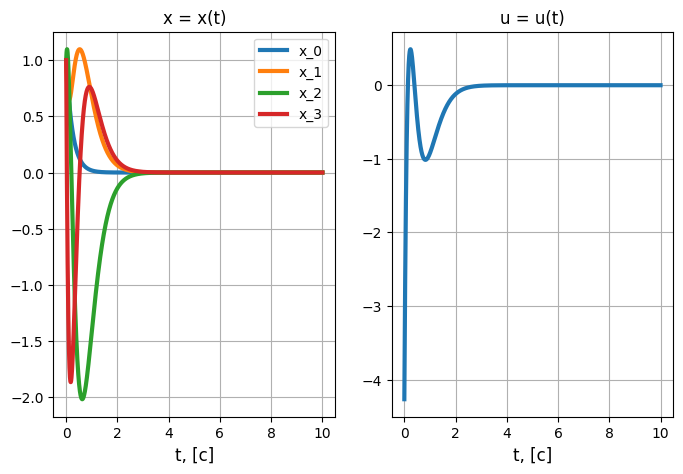

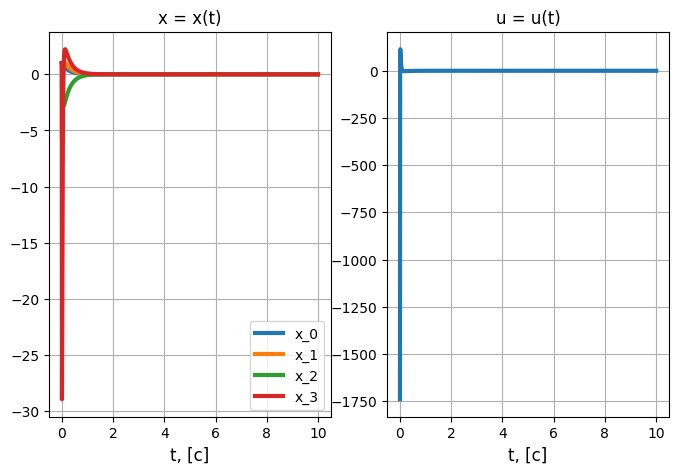

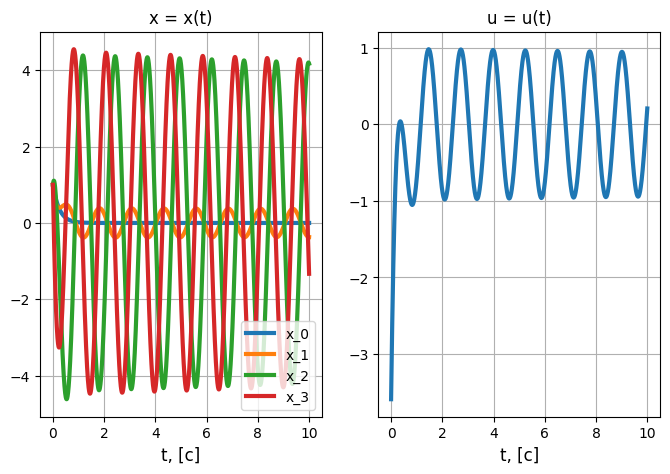

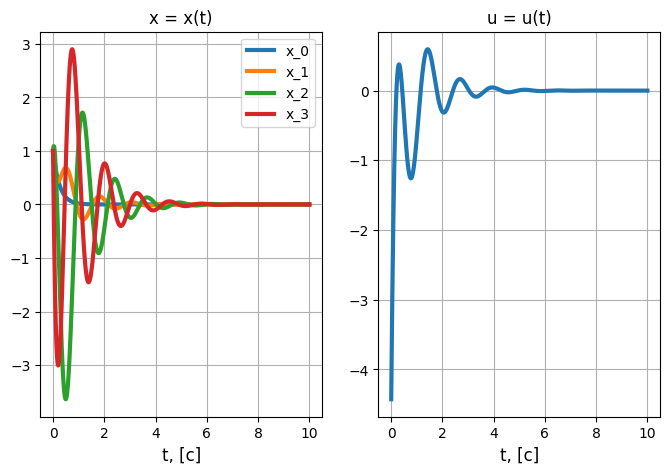

In [260]:
for indx, specs in enumerate(task1_specs):
    print(f'======== {specs} ========')
    new_g = np.diag(specs)
    new_y = np.ones((task1_B.shape[1], task1_A.shape[0]))
    for i in range(1, new_g.shape[0]):
        if new_g[i, i] == new_g[i-1, i-1]:
            new_g[i-1, i] = 1
    if specs[2].imag != 0:
        new_g[2, 2] = specs[2].real
        new_g[3, 3] = specs[2].real
        new_g[2, 3] = specs[2].imag
        new_g[3, 2] = -specs[2].imag
    
    # print(f'G:\n {new_g}')

    K = task1_get_K(task1_A, task1_B, new_g, new_y)
    print(K)
    ts = get_t(10)
    res = task1_simulate(task1_A, task1_B, K, task1_x0, ts)

    fig, axs = plt.subplots(1, 2, figsize=(8, 5))
    for i in range(4):
        axs[0].plot(ts, res.states[i], linewidth = 3, label='x_' +str(i))
    axs[0].grid(True)
    axs[0].legend()
    axs[0].set_title(f'x = x(t)', fontsize=12)
    axs[0].set_xlabel(f"t, [c]", fontsize=12)

    axs[1].plot(ts, (K @ res.states).reshape(-1), linewidth = 3)
    axs[1].grid(True)
    axs[1].set_title(f'u = u(t)', fontsize=12)
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    plt.savefig(f'{SAVE_PATH}/task1_{indx}.jpg')